In [61]:
#Define libraries
import numpy as np
import pandas as pd
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from glob import glob
import json
import os
import sys
from tqdm.notebook import tqdm
import argparse
import torch.utils.data
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import math, random
import pathlib
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import copy
import time 
from collections import defaultdict



from pathlib import Path
from PIL import Image
import matplotlib.patches as patches

from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


In [62]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1999
seed_everything(seed)

In [63]:
class CFG:
    isOneHot = False
    label_map = {'dot': 0, 'horizontal_bar' : 1, 'vertical_bar': 2, 'line': 3, 'scatter': 4}
    num_classes = 5
    batchSize = 32
    fold_train = 0

In [64]:
INPUT_DIR = '/kaggle/input/benetech-making-graphs-accessible'
train_image_paths = sorted(glob(os.path.join(INPUT_DIR, 'train/images/*.jpg')))
train_annotation_paths = sorted(glob(os.path.join(INPUT_DIR, 'train/annotations/*.json')))
print('train images:', len(train_image_paths))
print('train annotations:', len(train_annotation_paths))
args = argparse.Namespace(
    sampling_size = 10000,
    thresholds = [9, 128]
)

train images: 60578
train annotations: 60578


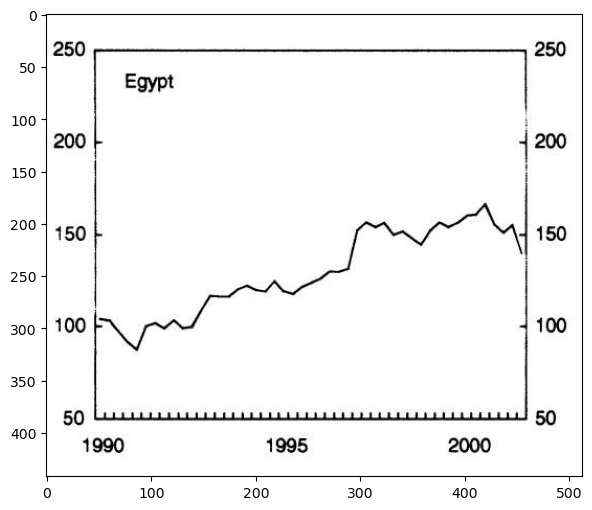

In [65]:
#load a random image from the training directory
plt.figure(figsize=(14, 6))
file_name = random.choice(train_image_paths)
image = plt.imread(file_name)
plt.imshow(image)
plt.show()

In [66]:
#load the annotations for the above graph
a = file_name.split("/")[-1]

split_file_path = file_name.split("/")
split_file_name = a.split(".")
json_file_path = INPUT_DIR+"/train/annotations/"+split_file_name[0]+".json"
annot = open(json_file_path)
annot = json.load(annot)
annot


{'source': 'extracted',
 'chart-type': 'line',
 'plot-bb': {'height': 355, 'width': 413, 'x0': 46, 'y0': 34},
 'text': [{'id': 0,
   'polygon': {'x0': 74,
    'x1': 123,
    'x2': 123,
    'x3': 74,
    'y0': 55,
    'y1': 55,
    'y2': 76,
    'y3': 76},
   'text': 'Egypt',
   'role': 'chart_title'},
  {'id': 1,
   'polygon': {'x0': 5,
    'x1': 38,
    'x2': 38,
    'x3': 5,
    'y0': 24,
    'y1': 24,
    'y2': 41,
    'y3': 41},
   'text': '250',
   'role': 'tick_label'},
  {'id': 2,
   'polygon': {'x0': 6,
    'x1': 39,
    'x2': 39,
    'x3': 6,
    'y0': 112,
    'y1': 112,
    'y2': 130,
    'y3': 130},
   'text': '200',
   'role': 'tick_label'},
  {'id': 3,
   'polygon': {'x0': 7,
    'x1': 39,
    'x2': 39,
    'x3': 7,
    'y0': 201,
    'y1': 201,
    'y2': 218,
    'y3': 218},
   'text': '150',
   'role': 'tick_label'},
  {'id': 4,
   'polygon': {'x0': 7,
    'x1': 39,
    'x2': 39,
    'x3': 7,
    'y0': 288,
    'y1': 288,
    'y2': 306,
    'y3': 306},
   'text': '100',

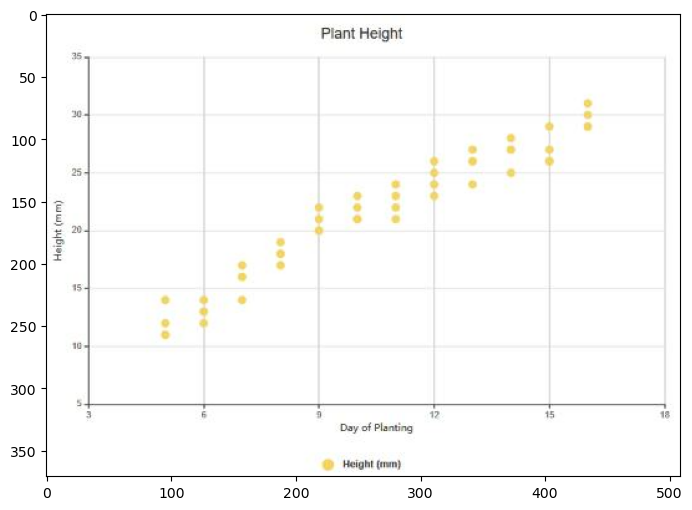

In [67]:
# loading a random image from the test directory
plt.figure(figsize=(14, 6))
file_name = random.choice(os.listdir(INPUT_DIR+"/test/images/"))
image = plt.imread(INPUT_DIR+"/test/images/"+file_name)
plt.imshow(image)
plt.show()

In [ ]:
#creating a dataframe with images and annotations for classification
train_df = pd.DataFrame({'image_path':train_image_paths})

train_df['train_annotations'] = train_df['image_path'].str.replace('images', 'annotations')
train_df['train_annotations'] = train_df['train_annotations'].str.replace('jpg', 'json')

chart_type, source, height, width = [], [], [], []
for annotations in tqdm(train_df['train_annotations']):
    annot = open(annotations)
    annot = json.load(annot)
    chart_type.append(annot['chart-type'])
    source.append(annot['source'])
    height.append(annot['plot-bb']['height'])
    width.append(annot['plot-bb']['width'])

train_df['chart_type'] = chart_type
train_df['source'] = source
train_df['height'] = height
train_df['width'] = width

  0%|          | 0/60578 [00:00<?, ?it/s]

In [9]:
train_df.head(10)

,image_path,train_annotations,chart_type,source,height,width
0,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,vertical_bar,generated,137,379
1,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,359,497
2,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,116,376
3,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,scatter,generated,230,415
4,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,421,507
5,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,scatter,generated,219,436
6,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,dot,generated,224,437
7,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,dot,generated,208,417
8,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,213,430
9,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,extracted,276,403


In [34]:
train_df.chart_type.value_counts()

line              24942
vertical_bar      19189
scatter           11243
dot                5131
horizontal_bar       73
Name: chart_type, dtype: int64

In [38]:
#data transformation
transforms_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transforms_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [69]:
class ImageCharts(torch.utils.data.Dataset):
    def __init__(self, df, transforms  = None): ### phase = train/test
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        name_img = self.df.iloc[idx]['image_path']
        img = cv.imread(name_img)
        img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
        img = cv.resize(img,(500,300))
        img = img.astype(np.float32)/255.0

        label = np.array(self.df.iloc[idx]['label'])

        if(self.transforms is not None):
            img = self.transforms(img)
        return img, label

In [10]:
def cv_split(Xtrain, ytrain, n_folds, seed):
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for num, (train_index, val_index) in enumerate(kfold.split(Xtrain, ytrain)):
        Xtrain.loc[val_index, 'fold'] = int(num)
    Xtrain['fold'] = Xtrain['fold'].astype(int)
    return Xtrain

meta_df = cv_split(train_df,train_df['chart_type'], 5, 42)
meta_df['label'] = meta_df['chart_type'].apply(lambda x: CFG.label_map[x])
meta_df.head(42)

,image_path,train_annotations,chart_type,source,height,width,fold,label
0,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,vertical_bar,generated,137,379,4,2
1,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,359,497,0,3
2,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,116,376,1,3
3,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,scatter,generated,230,415,4,4
4,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,421,507,2,3
5,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,scatter,generated,219,436,1,4
6,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,dot,generated,224,437,1,0
7,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,dot,generated,208,417,4,0
8,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,generated,213,430,3,3
9,/kaggle/input/benetech-making-graphs-accessibl...,/kaggle/input/benetech-making-graphs-accessibl...,line,extracted,276,403,0,3


In [12]:
meta_df['label']

0        2
1        3
2        3
3        4
4        3
        ..
60573    3
60574    3
60575    0
60576    3
60577    3
Name: label, Length: 60578, dtype: int64

In [71]:
#dataloaders
train_ds = ImageCharts(meta_df[meta_df.fold != CFG.fold_train].reset_index(), transforms=transforms_train)
val_ds = ImageCharts(meta_df[meta_df.fold == CFG.fold_train].reset_index(), transforms=transforms_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size= CFG.batchSize, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size= CFG.batchSize, shuffle=True)

torch.Size([32, 3, 300, 500])
torch.Size([32])
chart_type: dot


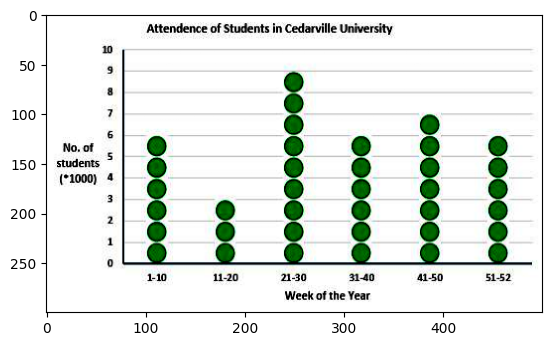

In [72]:
a,b = next(iter(train_dl))
print(a.shape)
print(b.shape)
print('chart_type:',list(CFG.label_map)[b[0].detach().numpy()])
plt.imshow(a[0].permute(1,2,0))

In [73]:
model = torchvision.models.resnet50(pretrained=False)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, CFG.num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = model.to(device)
next(myModel.parameters()).device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


device(type='cuda', index=0)

In [75]:
def training(model, train_dl, val_dl, num_epochs):
    
  # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
    best_acc = -1
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        

    # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            
            
        # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
            optimizer.zero_grad()

        # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Keep stats for Loss and Accuracy
            running_loss += loss.item()

        # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            if (i + 1) % 50 == 0:
                # print every 10 mini-batches
                print('Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}'
               .format(epoch + 1, num_epochs, i + 1, len(train_dl), running_loss/(i + 1)))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

    gt = []
    pred = []

    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0 
        for idx, data_ in enumerate(val_dl):
            inputs, labels = data_[0].to(device), data_[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep stats for Loss and Accuracy
            val_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            predi = torch.softmax(outputs, dim = -1)
            gt.append(labels)
            pred.append(predi[:,1])
            # Count of predictions that matched the target label
            correct += (prediction == labels).sum().item()
            total += prediction.shape[0]
        print('Accuracy of the network val: {:.4f} %'.format(100 * correct / total))

        final_score = 100 * correct / total


        if (best_acc < final_score):
            best_acc = final_score
            print("Saving best model!")
            torch.save(model.state_dict(), f'Benetech _ResNet50_fold0.pth')
    print('Finished Training')
num_epochs = 1   # Just for demo, adjust this higher.
training(myModel, train_dl, val_dl, num_epochs)

Epoch [1/1], Step [50/1515], Loss : 0.0171
Epoch [1/1], Step [100/1515], Loss : 0.0252
Epoch [1/1], Step [150/1515], Loss : 0.0427
Epoch [1/1], Step [200/1515], Loss : 0.0616
Epoch [1/1], Step [250/1515], Loss : 0.0670
Epoch [1/1], Step [300/1515], Loss : 0.0739
Epoch [1/1], Step [350/1515], Loss : 0.0854
Epoch [1/1], Step [400/1515], Loss : 0.0861
Epoch [1/1], Step [450/1515], Loss : 0.0916
Epoch [1/1], Step [500/1515], Loss : 0.0925
Epoch [1/1], Step [550/1515], Loss : 0.0876
Epoch [1/1], Step [600/1515], Loss : 0.0844
Epoch [1/1], Step [650/1515], Loss : 0.0841
Epoch [1/1], Step [700/1515], Loss : 0.0824
Epoch [1/1], Step [750/1515], Loss : 0.0800
Epoch [1/1], Step [800/1515], Loss : 0.0781
Epoch [1/1], Step [850/1515], Loss : 0.0773
Epoch [1/1], Step [900/1515], Loss : 0.0751
Epoch [1/1], Step [950/1515], Loss : 0.0727
Epoch [1/1], Step [1000/1515], Loss : 0.0709
Epoch [1/1], Step [1050/1515], Loss : 0.0695
Epoch [1/1], Step [1100/1515], Loss : 0.0673
Epoch [1/1], Step [1150/1515],

## SVM Model

In [27]:
img = cv.imread('/kaggle/input/benetech-making-graphs-accessible/train/images/0000ae6cbdb1.jpg')
print(img.shape)

(281, 466, 3)


In [37]:
counter = 0
flat_data_arr=[] 
target_arr=[]
for img in meta_df['image_path']:
        img_array=imread(img)
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(meta_df[meta_df['image_path']==img].label)
        if counter == 500:
            break
        counter+=1
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)


In [13]:
# flat_data

In [38]:
X = flat_data
y = target

In [39]:
print(X.size)

33817500


In [40]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,
                                               random_state=0)

In [31]:
print(x_test.size)
print(len(x_train[0]))

2767500
67500


In [41]:

clf = OneVsRestClassifier(SVC()).fit(X, y)
clf.predict(x_test)


array([3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 0, 2, 0, 3, 2,
       3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 0, 3, 3, 3, 2, 2, 2, 4,
       3, 3, 3, 2, 2, 3, 3, 4, 3, 0, 2, 2, 3, 3, 2, 3, 0, 2, 3, 3, 2, 0,
       3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 4, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3,
       2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2])

In [101]:

# clf = OneVsRestClassifier(SVC( C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, 
#                               tol=0.001,cache_size=200, class_weight=None, verbose=False, max_iter=-1,
#                               decision_function_shape='ovr', break_ties=False, random_state=None)).fit(X, y)
# clf.predict(x_test)


In [42]:
y_pred = clf.predict(x_train)
  
accuracy = accuracy_score(y_pred, y_train)
  

print(f"The model is {accuracy*100}% accurate")

The model is 85.0% accurate


In [44]:
y_test_pred = clf.predict(x_test)
  

accuracy = accuracy_score(y_test_pred, y_test)
  

print(f"The model is {accuracy*100}% accurate")

The model is 83.16831683168317% accurate


In [59]:
rbf = OneVsRestClassifier(SVC(gamma='auto',coef0=1.0)).fit(X, y)
rbf.predict(x_test)

array([3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 0, 2, 0, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 0, 3, 3, 3, 2, 2, 2, 3,
       3, 3, 3, 2, 3, 4, 3, 3, 2, 0, 2, 2, 3, 3, 3, 3, 0, 2, 3, 3, 2, 2,
       3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2])

In [60]:
y_pred = rbf.predict(x_train)
  
accuracy = accuracy_score(y_pred, y_train)
  

print(f"The model is {accuracy*100}% accurate")

The model is 76.75% accurate


In [53]:

model_poly = OneVsRestClassifier(SVC(kernel='poly',coef0=0.0,degree= 2,tol=0.1)).fit(X, y)
model_poly.predict(x_test)


array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 0, 2, 0, 3, 2,
       3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 2, 3, 0, 3, 3, 3, 2, 2, 2, 3,
       3, 3, 3, 2, 3, 4, 4, 3, 2, 0, 2, 2, 3, 3, 3, 3, 0, 2, 3, 3, 2, 0,
       3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2])

In [54]:
y_pred = model_poly.predict(x_train)
  

accuracy = accuracy_score(y_pred, y_train)
  

print(f"The model is {accuracy*100}% accurate")

The model is 75.5% accurate


In [25]:
model = OneVsRestClassifier(SVC(C=1, kernel='sigmoid')).fit(X, y)
model.predict(x_test)

array([3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 4, 4, 4, 2,
       3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2,
       3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 4, 4, 3, 3])

In [26]:
y_pred = model.predict(x_train)
  
accuracy = accuracy_score(y_pred, y_train)
  

print(f"The model is {accuracy*100}% accurate")

The model is 47.91666666666667% accurate


In [31]:
# flat_data_arr = []
# target_arr = []
# image_path = '/kaggle/input/benetech-making-graphs-accessible/train/images/0000ae6cbdb1.jpg'
# for img in image_path:
#         img_array=imread(img)
#         img_resized=resize(img_array,(150,150,3))
#         flat_data_arr.append(img_resized.flatten())
#         target_arr.append(meta_df[meta_df['image_path']==img].label)
    

# clf = OneVsRestClassifier(SVC()).fit(flat_data_arr,target_arr )
# clf.predict(x_test)

## bounding boxes of images (ocr)

In [41]:
annotations = Path("/kaggle/input/benetech-making-graphs-accessible/train/annotations")
images = Path("/kaggle/input/benetech-making-graphs-accessible/train/images")
all_annotations = list(annotations.iterdir())

In [42]:
def plot_with_annotations(filename, ax):
    with open(filename, "r") as f:
        row = pd.json_normalize(json.load(f)).iloc[0]
        
    img = Image.open(images / filename.with_suffix(".jpg").name)
    
    ax.imshow(img)
    bbox = patches.Rectangle(
        (row["plot-bb.x0"], row["plot-bb.y0"]), 
        row["plot-bb.width"], 
        row["plot-bb.height"], 
        linewidth=1, 
        edgecolor="r", 
        facecolor="none"
    )
    ax.add_patch(bbox)
    
    role2color = {
        'axis_title': "blue",
        'chart_title':"green",
        'legend_label':"yellow",
        'other':"grey",
        'tick_grouping':"brown",
        'tick_label':"purple",
    }
    
    for text in row["text"]:
        polygon = text["polygon"]
        xs = np.array([v for k, v in polygon.items() if "x" in k])
        ys = np.array([v for k, v in polygon.items() if "y" in k])
        xy = np.vstack([xs, ys]).T
        text_polygon = patches.Polygon(xy, linewidth=1, edgecolor=role2color[text["role"]], facecolor="none")
        ax.add_patch(text_polygon)

    
    ax.axis("off")

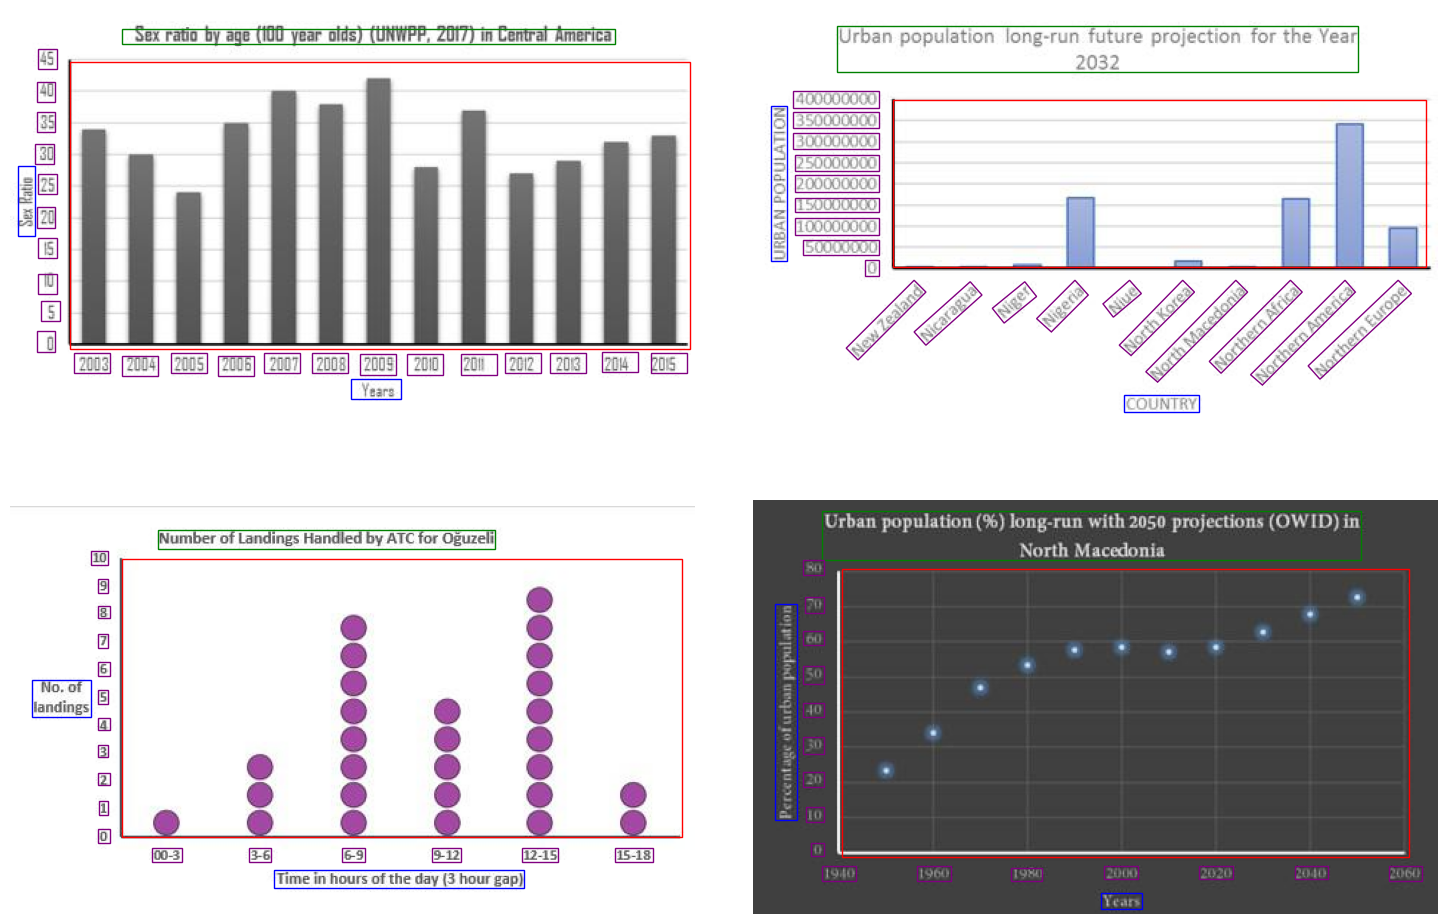

In [43]:
nrows, ncols = 2,2
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
fig.tight_layout()
ax = ax.flatten()

idxs = np.random.randint(low=0, high=len(all_annotations), size=nrows*ncols)

for i, idx in enumerate(idxs):
    plot_with_annotations(all_annotations[idx], ax[i])
    
plt.savefig("annotated_examples.pdf", bbox_inches="tight")